# サンプルベースのCMDPにおけるNatural Policy Gradient (モデルフリー)



---


今回のコードは[こちら](https://github.com/yu-ki3406/Syumi-note/blob/main/notebooks/NPG_CMDP.ipynb)のノートブックの続きで、前回のノートブックでは遷移確率$P$が既知の状態で求めていました。

今回は遷移確率が未知の状態で、最後のセクションでの部分をコードも含めて説明します。

コード内でのパラメータはすべて論文内のものに設定しました。

---


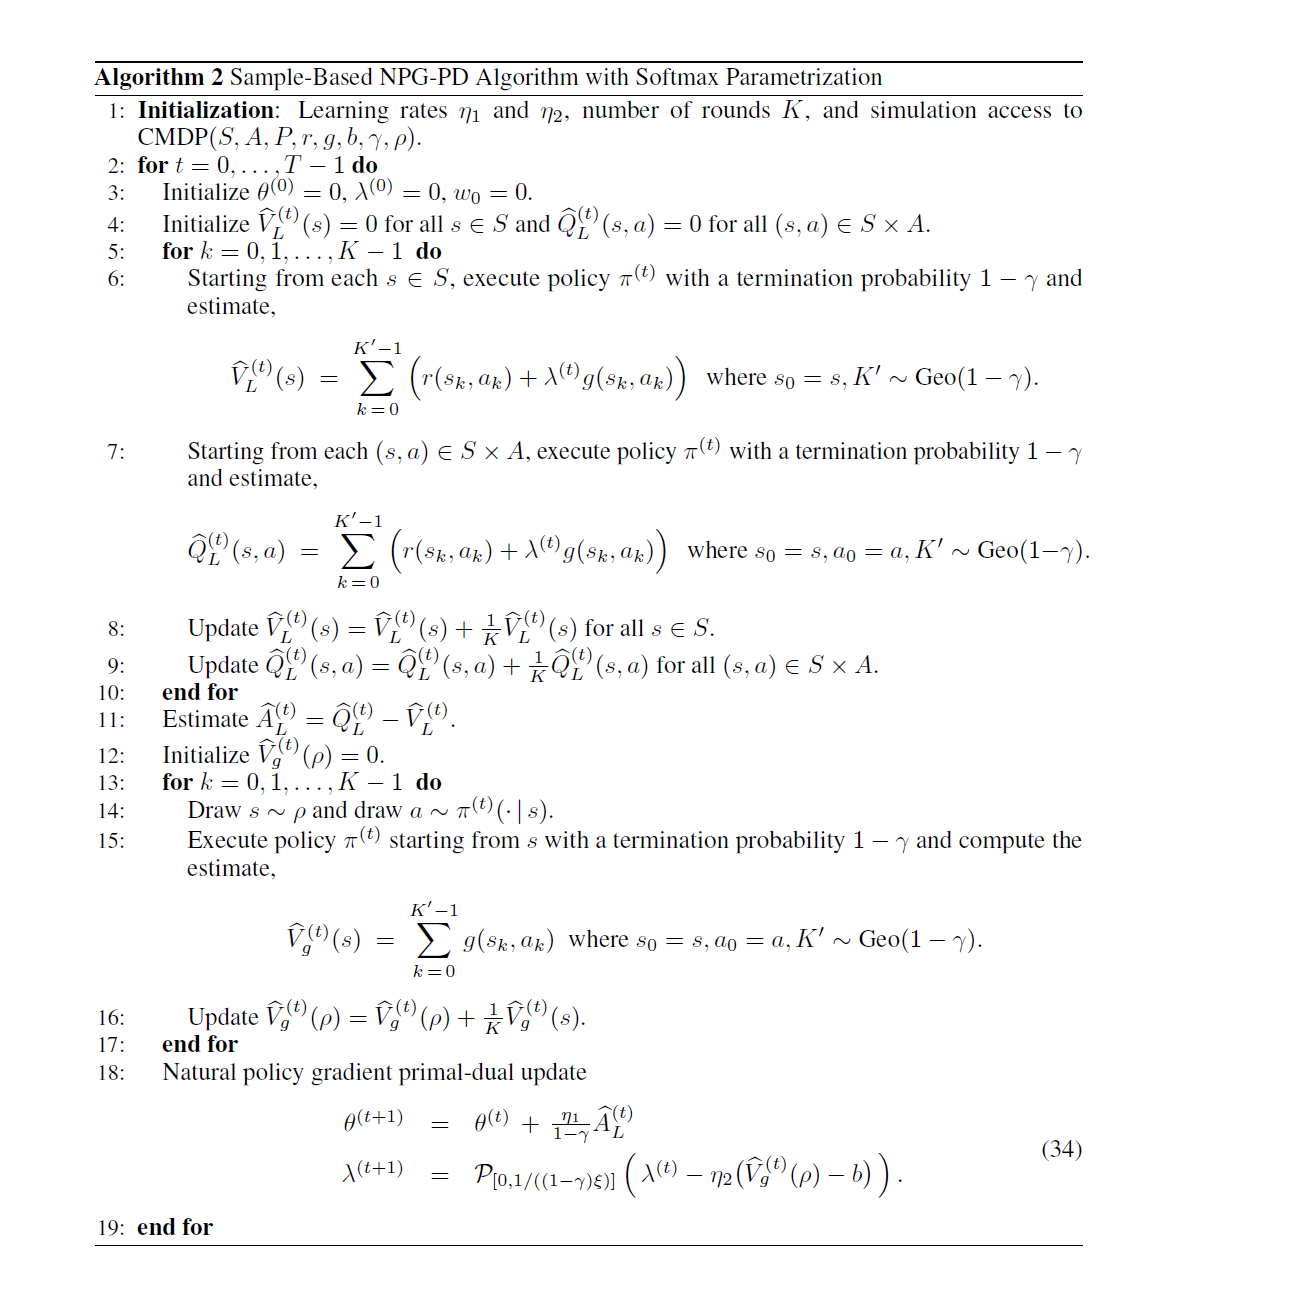


ここでのポイントはアルゴリズムにも書いているのですが、推定価値関数でどのくらいモンテカルロな推定をするかを決めるパラメータK'がありますね。

このK'をGeo(1-$\gamma$)からサンプルすることによって、次のことが成り立ちます。

\begin{aligned}
\mathbb{E}\left[\widehat{V}_g^{(t)}(s)\right] & =\mathbb{E}\left[\sum_{k=0}^{K^{\prime}-1} g\left(s_k, a_k\right) \mid \theta^{(t)}, s_0=s\right] \\
& =\mathbb{E}\left[\sum_{k=0}^{\infty} \mathbb{I}\left\{K^{\prime}-1 \geq k \geq 0\right\} g\left(s_k, a_k\right) \mid \theta^{(t)}, s_0=s\right] \\
& =\sum_{k=0}^{\infty} \mathbb{E}\left[\mathbb{E}_{K^{\prime}}\left[\mathbb{I}\left\{K^{\prime}-1 \geq k \geq 0\right\}\right] g\left(s_k, a_k\right) \mid \theta^{(t)}, s_0=s\right] \\
& =\sum_{k=0}^{\infty} \mathbb{E}\left[\gamma^k g\left(s_k, a_k\right) \mid \theta^{(t)}, s_0=s\right] \\
& =\mathbb{E}\left[\sum_{k=0}^{\infty} \gamma^k g\left(s_k, a_k\right) \mid \theta^{(t)}, s_0=s\right] \\
& =V_g^{(t)}(s)
\end{aligned}

In [1]:
import numpy as np
from docplex.mp.model import Model

# MDPの構築
from typing import NamedTuple ,Optional
np.random.seed(10)

S = 20 # 状態数
A = 10 # 行動数
S_set = np.arange(S)
A_set = np.arange(A)
gamma = 0.9 # 割引率

rew = np.random.uniform(0,1,size=(S,A)) # 報酬
rew = np.array(rew)

utility = np.random.uniform(0,1,size=(S,A))
utility = np.array(utility)


P = np.random.rand(S,A,S) # 遷移確率
P = P.reshape(S*A,S)
P = P/np.sum(P,axis=1,keepdims=True) # 正規化
P = P.reshape(S,A,S)
np.testing.assert_allclose(P.sum(axis=-1), 1, atol=1e-6)
rho = np.ones(S) /S
b = 3

class CMDP(NamedTuple):
    S_set: np.ndarray
    A_set: np.ndarray
    rew: np.ndarray
    utility: np.ndarray
    P: np.ndarray
    gamma: float
    H: int
    rho : np.ndarray
    b : int


    optimal_V: Optional[np.ndarray] = None

    @property
    def S(self):
        return len(self.S_set)

    @property
    def A(self):
        return len(self.A_set)

H = int (1/(1-gamma) + 100)
cmdp = CMDP(S_set,A_set,rew,utility,P,gamma,H,rho,b)

In [2]:
def theta_to_policy(theta: np.ndarray, cmdp: CMDP) -> np.ndarray:
    """θから方策を計算する"""
    '''[pi_(s1,a1),pi_(s1,a2),pi_(s1,a3),...]'''
    # ここを実装
    s = cmdp.S
    a = cmdp.A
    policy = []
    theta = theta - np.amax(theta)
    for i in range(s):
        norm = np.sum(np.exp(theta[a*i:a*(i+1)]))
        for j in range(a*i,a*(i+1)):
            policy.append(np.exp(theta[j])/norm)


    return np.array(policy)

def get_Pi(prob : np.ndarray,cmdp:CMDP) -> np.ndarray:
    #遷移確率と方策をdの計算を楽にするために求める。

    Pi = np.zeros((cmdp.S, cmdp.S * cmdp.A))
    for i in range(cmdp.S):
        Pi[i, i * cmdp.A:(i + 1) * cmdp.A] = prob[i * cmdp.A:(i + 1) * cmdp.A]

    return Pi

def V_from_Q(qvals:np.ndarray,prob:np.ndarray,rho:np.ndarray,cmdp:CMDP) -> np.ndarray:
    #価値関数の計算
    V = np.zeros(cmdp.S)
    for i in range(cmdp.S):
        for j in range(cmdp.A):
            V[i] += qvals[i*cmdp.A+j] * prob[i*cmdp.A+j]

    v_rho = np.dot(V,rho)
    return v_rho

#価値関数の推定
def Q_value_estimate(cmdp:CMDP,policy:np.ndarray,uti:np.ndarray,Ksample:int):
    s,a = cmdp.S,cmdp.A
    gamma = cmdp.gamma

    q_estimate = np.zeros((s,a))
    policy = policy.reshape(s,a)

    for _ in range(Ksample):
        qest = np.zeros((s,a))
        for i in range(s):
            for j in range(a):
                qest[i,j] = uti[i,j] #初期位置をs,aに設定してるため
                length = np.random.geometric(p=1-gamma,size=1)
                init_s = np.random.choice(cmdp.S_set,1,p=cmdp.P[i,j,:])
                state = init_s[0]

                for _ in range(length[0] - 1):
                    action = np.random.choice(cmdp.A_set,1,p=policy[state])[0]
                    qest[state,action] += uti[state,action]
                    state = np.random.choice(cmdp.S_set,1,p=cmdp.P[state,action,:])[0]
        q_estimate += qest

    return q_estimate/Ksample

#制約条件のλの更新
def proj(scalar):
    offset = 100
    if scalar < 0:
        scalar = 0
    
    if scalar > offset:
        scalar = offset
    
    return scalar


最適な価値関数を線形計画法で求める。


In [25]:
model = Model('CMDP')
idx = [(i,j) for i in range(cmdp.S) for j in range(cmdp.A)]
policy = model.continuous_var_dict(idx)

for s in range(cmdp.S):
    for a in range(cmdp.A):
        model.add_constraint(policy[(s,a)] >= 0)
        model.add_constraint(policy[(s,a)] <= 1)

model.add_constraint(model.sum(policy[(s,a)] * cmdp.utility[s,a] / (1-gamma) for s in range(cmdp.S) for a in range(cmdp.A)) >= b)


for s_next in range(cmdp.S):
    model.add_constraint(
        gamma * model.sum(policy[(s,a)] * cmdp.P[s,a,s_next] for s in range(cmdp.S) for a in range(cmdp.A)) 
        + (1 - cmdp.gamma) * cmdp.rho[s_next] == model.sum(policy[(s_next,a_next)] for a_next in range(cmdp.A))
    )


model.maximize(model.sum(policy[(s,a)] * cmdp.rew[s,a]/(1-gamma) for s in range(cmdp.S) for a in range(cmdp.A)))
# model.maximize(model.dot(cmdp.rho[s],(policy[(s,a)] * cmdp.rew[s,a]/(1-gamma) for s in range(cmdp.S) for a in range(cmdp.A))))  
# v = model.sum(policy * cmdp.rew/(1-gamma),axis=1)
# model.maximize(model.dot(cmdp.rho,v))

In [26]:
solution = model.solve()

In [27]:
solution.get_objective_value()

8.552624829749226

In [28]:
from tqdm import tqdm
N = 300
theta = np.random.uniform(0,1,size=(cmdp.S*cmdp.A))
dual = 0
gap = []
violation = []
avg_gap = 0
avg_violation = 0
div_number = 0
K_samples = 200
step = 0.1
dual_step = 0.1
S = cmdp.S
A = cmdp.A
vio = 0
for t in tqdm(range(N)):
    policy = theta_to_policy(theta,cmdp)
    Pi = get_Pi(policy,cmdp)
    #逆行列から価値関数を求める。
    P = cmdp.P.reshape(S*A,S)
    mat = np.identity(S*A) - gamma * np.matmul(P,Pi)

    #価値関数の計算
    qr_val = np.matmul(np.linalg.inv(mat),cmdp.rew.reshape(S*A))
    qr_val = qr_val.reshape(S,A)

    qg_val = np.matmul(np.linalg.inv(mat),cmdp.utility.reshape(S*A))
    qg_val = qg_val.reshape(S,A)

    q_est = Q_value_estimate(cmdp,policy,cmdp.rew+dual*cmdp.utility,K_samples)
    v_est = np.zeros(S)
    
    policy = policy.reshape(S,A)
    v_est = (policy * q_est).sum(axis=1)
    v_est = v_est.reshape(20,1)
    v_est = np.tile(v_est,10) 
    #advantage 
    adv = q_est - v_est

    qg_est = Q_value_estimate(cmdp,policy,cmdp.utility,K_samples)
    vg_est = np.zeros(S)
    vg_est = (policy * qg_est).sum(axis=1)
    
    vg_val = np.dot(vg_est.T,cmdp.rho)
    # print(vg_val)
    if vg_val < b:
        vio += 1
    # print(adv.shape)
    theta = theta.reshape(S,A)

    theta += step * adv/(1-cmdp.gamma)
    theta = theta.reshape(S*A)
    dual = proj(dual - dual_step * (vg_val-b))

    if t % 5 == 0:
        ave_v = (policy * qr_val).sum(axis=1)
        ave_v = np.dot(ave_v.T,cmdp.rho)
        print(f'vioaltionしてる数は{vio}')  
        print(f'最適な価値関数とNPG_Sampleで求めた差は{ave_v - solution.get_objective_value()}')


  0%|          | 1/300 [00:28<2:21:39, 28.43s/it]

vioaltionしてる数は1
最適な価値関数とNPG_Sampleで求めた差は-3.8045259084633454


  2%|▏         | 6/300 [02:59<2:34:36, 31.55s/it]

vioaltionしてる数は1
最適な価値関数とNPG_Sampleで求めた差は-0.3919943699516164


  4%|▎         | 11/300 [05:30<2:26:33, 30.43s/it]

vioaltionしてる数は1
最適な価値関数とNPG_Sampleで求めた差は-0.39177923384093916


  5%|▌         | 16/300 [08:06<2:28:45, 31.43s/it]

vioaltionしてる数は1
最適な価値関数とNPG_Sampleで求めた差は-0.39177923385249436


  7%|▋         | 21/300 [10:30<2:13:46, 28.77s/it]

vioaltionしてる数は1
最適な価値関数とNPG_Sampleで求めた差は-0.39177923385249436


  9%|▊         | 26/300 [12:46<2:05:14, 27.43s/it]

vioaltionしてる数は1
最適な価値関数とNPG_Sampleで求めた差は-0.39177923385249436


 10%|█         | 31/300 [15:02<2:03:19, 27.51s/it]

vioaltionしてる数は1
最適な価値関数とNPG_Sampleで求めた差は-0.39177923385249436


 12%|█▏        | 36/300 [17:19<2:00:36, 27.41s/it]

vioaltionしてる数は1
最適な価値関数とNPG_Sampleで求めた差は-0.39177923385249436


 14%|█▎        | 41/300 [19:33<1:56:24, 26.97s/it]

vioaltionしてる数は1
最適な価値関数とNPG_Sampleで求めた差は-0.39177923385249436


 15%|█▌        | 46/300 [21:50<1:54:52, 27.14s/it]

vioaltionしてる数は1
最適な価値関数とNPG_Sampleで求めた差は-0.39177923385249436


 17%|█▋        | 51/300 [24:03<1:51:09, 26.78s/it]

vioaltionしてる数は1
最適な価値関数とNPG_Sampleで求めた差は-0.39177923385249436


 19%|█▊        | 56/300 [26:14<1:46:35, 26.21s/it]

vioaltionしてる数は1
最適な価値関数とNPG_Sampleで求めた差は-0.39177923385249436


 20%|██        | 61/300 [28:25<1:44:18, 26.18s/it]

vioaltionしてる数は1
最適な価値関数とNPG_Sampleで求めた差は-0.39177923385249436


 22%|██▏       | 66/300 [30:35<1:41:30, 26.03s/it]

vioaltionしてる数は1
最適な価値関数とNPG_Sampleで求めた差は-0.39177923385249436


 24%|██▎       | 71/300 [32:47<1:40:01, 26.21s/it]

vioaltionしてる数は1
最適な価値関数とNPG_Sampleで求めた差は-0.39177923385249436


 25%|██▌       | 76/300 [35:19<1:56:29, 31.20s/it]

vioaltionしてる数は1
最適な価値関数とNPG_Sampleで求めた差は-0.39177923385249436


 27%|██▋       | 81/300 [38:17<2:07:10, 34.84s/it]

vioaltionしてる数は1
最適な価値関数とNPG_Sampleで求めた差は-0.39177923385249436


 29%|██▊       | 86/300 [40:58<1:56:41, 32.72s/it]

vioaltionしてる数は1
最適な価値関数とNPG_Sampleで求めた差は-0.39177923385249436


 30%|███       | 91/300 [43:36<1:50:40, 31.77s/it]

vioaltionしてる数は1
最適な価値関数とNPG_Sampleで求めた差は-0.39177923385249436


 30%|███       | 91/300 [43:55<1:40:54, 28.97s/it]


KeyboardInterrupt: 